## This notebook is meant to further investigate model performance

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import linregress
from bltools import letter_subplots
from scipy.spatial import distance

load up the performances of each model (excluding HR red because it clearly was worse)

In [235]:
topHRperf = "../TOPMODS/hr_greyscale/QBC.csv"
topRRperf_grey = "../TOPMODS/rr_greyscale/QBC.csv"
topRRperf_red = "../TOPMODS/rr_redscale/QBC.csv"
topHR_RRperf_grey = "../TOPMODS/hr_rr_greyscale/QBC.csv"
topHR_RRperf_red  = "../TOPMODS/hr_rr_redscale/QBC.csv"

perfs = [topHRperf, topRRperf_red, topRRperf_grey, topHR_RRperf_grey, topHR_RRperf_red]
perfnames =  'topHRperf,topRRperf_red,topRRperf_grey,topHR_RRperf_grey,topHR_RRperf_red'.split(',')

In [236]:
experiment2perfdf = dict(zip(perfnames,[pd.read_csv(perf) for perf in perfs]))

Unpack some useful lists of values

In [237]:
HRg        = experiment2perfdf['topHRperf'].QBC_hr.values.tolist()
HR_RRg__HR = experiment2perfdf['topHR_RRperf_grey'].QBC_hr.values.tolist()
HR_RRr__HR = experiment2perfdf['topHR_RRperf_red'].QBC_hr.values.tolist()
HR_RRg__RR = experiment2perfdf['topHR_RRperf_grey'].QBC_rr.values.tolist()
HR_RRr__RR = experiment2perfdf['topHR_RRperf_red'].QBC_rr.values.tolist()
RRg        = experiment2perfdf['topRRperf_grey'].QBC_rr.values.tolist()
RRr        = experiment2perfdf['topRRperf_red'].QBC_rr.values.tolist()

HR_actual = experiment2perfdf['topHRperf'].actual_hr.values.tolist()
RR_actual = experiment2perfdf['topRRperf_grey'].actual_rr.values.tolist()
cols = 'HRg,HR_RRg__HR,HR_RRr__HR,HR_RRg__RR,HR_RRr__RR,RRg,RRr'.split(',')


perfdf = pd.DataFrame(dict(zip(cols,[HRg,
                                     HR_RRg__HR,HR_RRr__HR,
                                     HR_RRg__RR,HR_RRr__RR,
                                     RRg,RRr])))

In [238]:
perfdf

,HR_RRg__HR,HR_RRg__RR,HR_RRr__HR,HR_RRr__RR,HRg,RRg,RRr
0,87.254967,22.565655,88.569260,14.856959,96.294739,18.978716,26.634035
1,64.157242,18.764334,69.311409,26.730856,60.941357,21.530914,25.015287
2,71.662086,24.256742,75.873703,17.126810,74.327477,24.615618,20.950340
3,75.887962,19.988165,66.083862,21.216692,70.026253,21.777353,19.148842
4,77.840187,21.208845,69.000862,22.378723,73.861900,21.361437,20.351530
5,82.445854,22.561756,78.195053,27.742348,82.999641,23.099003,25.100145
6,42.335030,14.199823,73.115723,21.644020,62.956249,24.920742,22.651264
7,75.430923,20.714577,76.341400,18.125044,74.757645,23.344629,24.353687
8,101.551949,25.344078,90.883896,27.947073,102.632843,23.200422,25.438570
9,75.795738,22.589287,81.038170,29.182095,77.463943,23.252754,25.231821


Defining some plotting related functions

In [239]:
def add_subplot_axes(ax,rect):
    """
    add subsubplot
    
    *=============================*
    |      *------*     __        |
    |      |subsub|    |  |       |
    |   _  |plot  |    |  |__     |
    |__|  |*------*  __|     |____|
    |     |_________|        |    |
    *==============================*
    """
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

def bland_altman(actual, predictions):
    actual, predictions = map(np.log2, map(np.array, [actual,predictions]))
    diff = actual - predictions
    avg  = (actual + predictions)/2
    
    return avg, diff

Draw HR performance plot

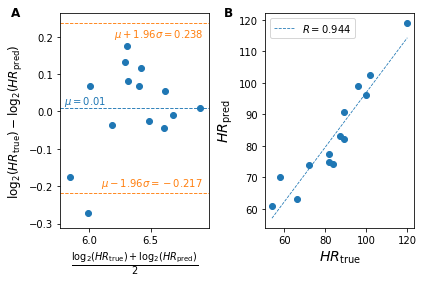

In [321]:
slope, intercept, r, p, err = linregress(HR_actual, HRg)
def fit(X):
    return slope*X + intercept

Xs = np.arange(min(HR_actual), max(HR_actual)+1)
layout = (2,4)
fig = plt.figure()
[ax, ax2] = [plt.subplot2grid(layout, (0,0), colspan=2, rowspan=2),
             plt.subplot2grid(layout, (0,2), rowspan=2, colspan=2)]

letter_subplots([ax, ax2], xoffset=[-0.3, -0.25], yoffset=[1., 1.])

ax2.scatter(HR_actual, HRg)
ax2.plot(Xs, fit(Xs), label=f"$R={round(r,3)}$", linestyle='--', linewidth=0.8)
ax2.set_ylabel("$HR_{\mathrm{pred}}$", fontsize=14)
ax2.set_xlabel("$HR_{\mathrm{true}}$", fontsize=14)
ax2.legend(frameon=True)
avg, diff = bland_altman(HR_actual, HRg)
std_diff196 = np.std(diff)*1.96
plus = np.mean(diff) + std_diff196
minus = np.mean(diff) - std_diff196

kwds = {'linestyle':'--','linewidth':0.9}
ax.scatter(avg, diff)
ax.text(5.8, np.mean(diff) + 0.01, f"$\mu= {round(np.mean(diff),3)}$", color="C0")
ax.text(6.2,0.2,rf"$\mu + 1.96\sigma={round(plus,3)}$", color="C1")
ax.text(6.1,-0.2,rf"$\mu - 1.96\sigma={round(minus,3)}$", color="C1")
ax.set_xlabel(r"$\frac{\log_{2}(HR_{\mathrm{true}}) + \log_{2}(HR_{\mathrm{pred}})}{2}$", fontsize=14)
ax.set_ylabel(r"$\log_{2}(HR_{\mathrm{true}}) - \log_{2}(HR_\mathrm{pred})$", fontsize=12)
ax.axhline(np.mean(diff), **kwds)
ax.axhline(plus, **kwds, color="C1")
ax.axhline(minus, **kwds, color="C1")
plt.tight_layout(w_pad=0.4)
plt.savefig("figs/HRperformance.pdf")
plt.show()

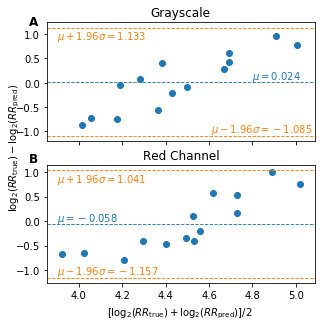

Correlation in preds RR gray: 0.1354974877530401
Correlation in preds RR red:0.02533939710370304


In [319]:
slope, intercept, r, p, err = linregress(RR_actual, RRg)
def fit(X):
    return slope*X + intercept

slope_r, intercept_r, rr, pr, errr = linregress(RR_actual, RRr)
def fitred(X):
    return slope_r*X + intercept_r
    

Xs = np.arange(min(RR_actual), max(RR_actual)+1)
layout=(2,4)
#fig = plt.figure(figsize=(6.4*0.75, 4.8))
fig, [ax, ax2] = plt.subplots(2,1,figsize=(6.4*0.75, 4.8), sharex=True)   #= [plt.subplot2grid(layout, (0,0), colspan=2, rowspan=2),
                #  plt.subplot2grid(layout, (0,2), rowspan=2, colspan=2)]
                       #plt.subplot2grid(layout, (2,2), rowspan=2, colspan=2)]
kwds = {'linestyle':'--','linewidth':0.9}

letter_subplots([ax, ax2], xoffset=[-0.05, -0.05], yoffset=[1.01, 1.05])

avg, diff = bland_altman(RR_actual, RRg)
std_diff196 = np.std(diff)*1.96
plus = np.mean(diff) + std_diff196
minus = np.mean(diff) - std_diff196

ax.scatter(avg, diff)
# mu
ax.text(4.8, np.mean(diff) + 0.05, f"$\mu = {round(np.mean(diff),3)}$", color="C0")
# mu +
ax.text(3.9,0.89,rf"$\mu + 1.96\sigma={round(plus,3)}$", color="C1")
# mu -
ax.text(4.61,-1.02,rf"$\mu - 1.96\sigma={round(minus,3)}$", color="C1")
#ax.text(0, r"$\log_{2}(RR_{\mathrm{true}}) - \log_{2}(RR_\mathrm{pred})$", fontsize=12)
ax.axhline(np.mean(diff), **kwds)
ax.axhline(plus, **kwds, color="C1")
ax.axhline(minus, **kwds, color="C1")
ax.set_title("Grayscale")

avg, diff = bland_altman(RR_actual, RRr)
std_diff196 = np.std(diff)*1.96
plus = np.mean(diff) + std_diff196
minus = np.mean(diff) - std_diff196

ax2.scatter(avg, diff)
# mu
ax2.text(3.9, np.mean(diff) + 0.05, f"$\mu = {round(np.mean(diff),3)}$", color="C0")
# mu +
ax2.text(3.9,0.8,rf"$\mu + 1.96\sigma={round(plus,3)}$", color="C1")
# mu -
ax2.text(3.9,-1.09,rf"$\mu - 1.96\sigma={round(minus,3)}$", color="C1")
ax2.axhline(np.mean(diff), **kwds)
ax2.axhline(plus, **kwds, color="C1")
ax2.axhline(minus, **kwds, color="C1")
ax2.set_title("Red Channel")

fig.text(0.01, 0.52, r'$\log_{2}(RR_{\mathrm{true}}) - \log_{2}(RR_{\mathrm{pred}})$', va='center', rotation='vertical')
fig.text(0.3 ,0.04, r"$[\log_{2}(RR_{\mathrm{true}}) + \log_{2}(RR_{\mathrm{pred}})]/2$", va='center')
#plt.tight_layout(w_pad=1.5)
#plt.subplots_adjust(top=1)#left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig("figs/RRperformance.pdf")
plt.show()
print(f'Correlation in preds RR gray: {r}')
print(f"Correlation in preds RR red:{rr}")

In [247]:
#HR_RRg__HR, HR_RRg__RR, HR_RRr__HR, HR_RRr__RR
simul_df_hr = pd.DataFrame({'actual_hr':HR_actual, 'grey':HR_RRg__HR, 'red':HR_RRr__HR})
simul_df_rr = pd.DataFrame({'actual_rr':RR_actual, 'grey':HR_RRg__RR, 'red':HR_RRr__RR})

In [248]:
simul_df_hr

,actual_hr,grey,red
0,100.0,87.254967,88.569260
1,54.0,64.157242,69.311409
2,84.0,71.662086,75.873703
3,58.0,75.887962,66.083862
4,72.0,77.840187,69.000862
5,87.0,82.445854,78.195053
6,66.0,42.335030,73.115723
7,82.0,75.430923,76.341400
8,102.0,101.551949,90.883896
9,82.0,75.795738,81.038170


In [251]:
simul_df_rr['SE_red'] = (simul_df_rr['actual_rr'] - simul_df_rr['red'])**2
simul_df_rr['SE_grey'] = (simul_df_rr['actual_rr'] - simul_df_rr['grey'])**2

In [255]:
print(simul_df_rr['SE_red'].mean())
print(simul_df_rr['SE_grey'].mean())

106.9473951386287
94.63406652800248


In [257]:
simul_df_hr['SE_red'] = (simul_df_hr['actual_hr'] - simul_df_hr['red'])**2
simul_df_hr['SE_grey'] = (simul_df_hr['actual_hr'] - simul_df_hr['grey'])**2

In [259]:
print(simul_df_hr['SE_red'].mean())
print(simul_df_hr['SE_grey'].mean())

82.26441071737125
115.88603891608156


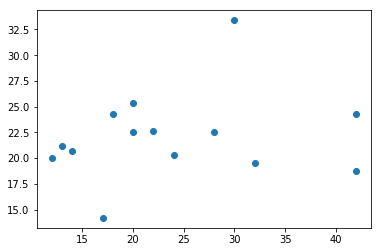

In [278]:
preds_hr_red = np.array(simul_df_hr['red'].values.tolist())
diff_hr_red = np.array(HR_actual) - preds_hr_red

preds_rr_grey = np.array(simul_df_rr['grey'].values.tolist())
diff_rr_grey = np.array(RR_actual) - preds_rr_red

plt.scatter(RR_actual, preds_rr_grey)
plt.show()

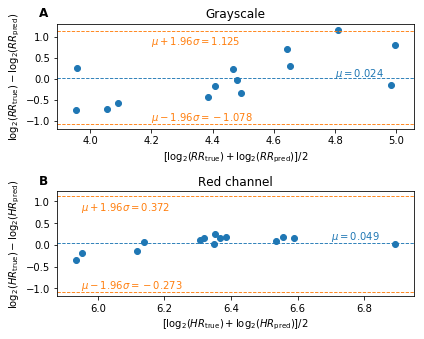

In [378]:
fig, [ax1, ax2] = plt.subplots(2,figsize=(6.4*0.75*1.25, 4.8))
letter_subplots([ax1,ax2],xoffset=[-0.038,-0.038], yoffset=[1.1,1.1])

avg, diff = bland_altman(RR_actual, simul_df_rr['grey'].values.tolist())
mean_RR = np.mean(diff)
plus = mean_RR + np.std(diff)*1.96
minus = mean_RR - np.std(diff)*1.96

ax1.set_title("Grayscale")
ax1.set_xlabel(r"$[\log_{2}(RR_{\mathrm{true}}) + \log_{2}(RR_{\mathrm{pred}})]/2$")
ax1.scatter(avg, diff)
ax1.axhline(plus, **kwds,color="C1")
ax1.axhline(mean_RR, **kwds)
ax1.axhline(minus, **kwds, color="C1")
# plus
ax1.text(4.2,0.8, rf"$\mu + 1.96\sigma={round(plus,3)}$", color="C1")
# minus
ax1.text(4.2,-1., rf"$\mu - 1.96\sigma={round(minus,3)}$", color="C1")
# mu
ax1.text(4.8, mean_RR + 0.025, rf"$\mu={round(mean_RR, 3)}$",color="C0")

avg2, diff2 = bland_altman(HR_actual, simul_df_hr['red'].values.tolist())
mean_HR = np.mean(diff2)
plus2 = mean_HR + np.std(diff2)*1.96
minus2 = mean_HR - np.std(diff2)*1.96

ax2.set_title("Red channel")
ax2.scatter(avg2, diff2)
ax2.axhline(plus, **kwds,color="C1")
ax2.axhline(mean_HR, **kwds)
ax2.axhline(minus, **kwds, color="C1")
# plus
ax2.text(5.95,0.8, rf"$\mu + 1.96\sigma={round(plus2,3)}$", color="C1")
# minus
ax2.text(5.95,-1, rf"$\mu - 1.96\sigma={round(minus2,3)}$", color="C1")
# mu
ax2.text(6.7, mean_RR + 0.1, rf"$\mu={round(mean_HR, 3)}$",color="C0")

ax2.set_xlabel(r"$[\log_{2}(HR_{\mathrm{true}}) + \log_{2}(HR_{\mathrm{pred}})]/2$")
ax1.set_ylabel(r"$\log_{2}(RR_\mathrm{true}) - \log_{2}(RR_\mathrm{pred})$")
ax2.set_ylabel(r"$\log_{2}(HR_\mathrm{true}) - \log_{2}(HR_\mathrm{pred})$")

#plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.savefig("figs/HR_RR_performance.pdf")
plt.show()

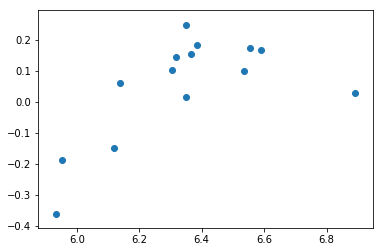